# Import librairies

In [1]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import plotly.express as px
import plotly.graph_objs as go

font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
sns.set(font_scale=3)

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans

# Outils

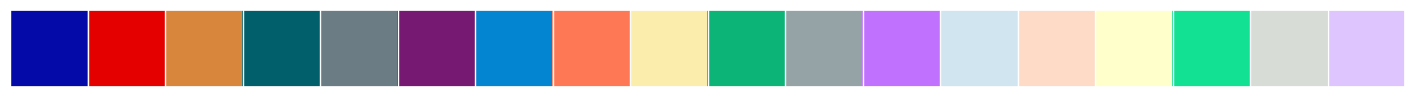

In [3]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
          ]
sns.palplot(sns.color_palette(palette))

In [4]:
repertoireRacine  = '.'
nomProjet         = 'Travail_Donnees_Meteo'

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

In [5]:
donnees = pd.read_parquet("donnees/donnees_meteo.gzip")
donnees.set_index(['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],inplace=True)

In [6]:
donnees[['VitesseVent','Temperature','Humidite','Pression','Visibilite','Precipitation']].head()

VitesseVent  Temperature  \
Nom       Latitude Longitude Altitude Zone                             
Abbeville 50.136   1.834     69       NO            2.0         2.89   
                                      NO            3.0         2.70   
                                      NO            3.0         2.89   
                                      NO            4.1         3.60   
                                      NO            5.1         4.39   

                                            Humidite  Pression  Visibilite  \
Nom       Latitude Longitude Altitude Zone                                   
Abbeville 50.136   1.834     69       NO        99.0     990.9         NaN   
                                      NO        99.0     990.7         NaN   
                                      NO        99.0     990.9         0.1   
                                      NO        99.0     991.1         0.8   
                                      NO        99.0     990.4         1.6   

                                            Precipitation  
Nom       Latitude Longitude Altitude Zone                 
Abbeville 50.136   1.834     69       NO              0.0  
                                      NO              0.2  
                                      NO              0.0  
                                      NO              0.0  
                                      NO              0.0

# Moyenne mensuelle par ville  

In [7]:
donneesM = donnees.reset_index().pivot_table(index=['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],
                                 columns='Mois',
                                 values=['VitesseVent','Temperature','Humidite','Pression','Visibilite','Precipitation'],  
                                 aggfunc = 'mean',
                                 sort = False)
donneesM.columns=[f'{column[0]}{column[1]:02d}' for column in donneesM.columns]
donneesM.to_parquet(os.path.join(repertoireDonnees,'donneesM.gzip'),compression='gzip', engine='pyarrow') 
donneesM.head()

VitesseVent01  \
Nom             Latitude  Longitude Altitude Zone                  
Abbeville       50.136000  1.834000 69       NO         4.823287   
Lille           50.570000  3.097500 47       NE         4.927085   
Pte De La Hague 49.725167 -1.939833 6        NO         8.753994   
Caen            49.180000 -0.456167 67       NO         5.096786   
Rouen           49.383000  1.181667 151      NO         4.694994   

                                                   VitesseVent02  \
Nom             Latitude  Longitude Altitude Zone                  
Abbeville       50.136000  1.834000 69       NO         5.042601   
Lille           50.570000  3.097500 47       NE         5.131767   
Pte De La Hague 49.725167 -1.939833 6        NO         8.572726   
Caen            49.180000 -0.456167 67       NO         5.257093   
Rouen           49.383000  1.181667 151      NO         4.856260   

                                                   VitesseVent03  \
Nom             Latitude  Longitude Altitude Zone                  
Abbeville       50.136000  1.834000 69       NO         4.722931   
Lille           50.570000  3.097500 47       NE         4.698451   
Pte De La Hague 49.725167 -1.939833 6        NO         7.517303   
Caen            49.180000 -0.456167 67       NO         4.698784   
Rouen           49.383000  1.181667 151      NO         4.557634   

                                                   VitesseVent04  \
Nom             Latitude  Longitude Altitude Zone                  
Abbeville       50.136000  1.834000 69       NO         4.246013   
Lille           50.570000  3.097500 47       NE         4.227831   
Pte De La Hague 49.725167 -1.939833 6        NO         6.554879   
Caen            49.180000 -0.456167 67       NO         4.156211   
Rouen           49.383000  1.181667 151      NO         4.148104   

                                                   VitesseVent05  \
Nom             Latitude  Longitude Altitude Zone                  
Abbeville       50.136000  1.834000 69       NO         4.155940   
Lille           50.570000  3.097500 47       NE         4.123952   
Pte De La Hague 49.725167 -1.939833 6        NO         6.205759   
Caen            49.180000 -0.456167 67       NO         3.965572   
Rouen           49.383000  1.181667 151      NO         3.986387   

                                                   VitesseVent06  \
Nom             Latitude  Longitude Altitude Zone                  
Abbeville       50.136000  1.834000 69       NO         3.828119   
Lille           50.570000  3.097500 47       NE         3.831644   
Pte De La Hague 49.725167 -1.939833 6        NO         5.713807   
Caen            49.180000 -0.456167 67       NO         3.679176   
Rouen           49.383000  1.181667 151      NO         3.665799   

                                                   VitesseVent07  \
Nom             Latitude  Longitude Altitude Zone                  
Abbeville       50.136000  1.834000 69       NO         3.897857   
Lille           50.570000  3.097500 47       NE         3.844869   
Pte De La Hague 49.725167 -1.939833 6        NO         5.627601   
Caen            49.180000 -0.456167 67       NO         3.911306   
Rouen           49.383000  1.181667 151      NO         3.676522   

                                                   VitesseVent08  \
Nom             Latitude  Longitude Altitude Zone                  
Abbeville       50.136000  1.834000 69       NO         3.690614   
Lille           50.570000  3.097500 47       NE         3.583466   
Pte De La Hague 49.725167 -1.939833 6        NO         5.822711   
Caen            49.180000 -0.456167 67       NO         3.847381   
Rouen           49.383000  1.181667 151      NO         3.471330   

                                                   VitesseVent09  \
Nom             Latitude  Longitude Altitude Zone                  
Abbeville       50.136000  1.834000 69       NO         3.683132   
Lille           50.570000  3.09

# Moyenne journalière  par ville 

In [8]:
donneesJ = donnees.reset_index().pivot_table(index=['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],
                                 columns='JourA',
                                 values=['VitesseVent','Temperature','Humidite','Pression','Visibilite','Precipitation'],  
                                 aggfunc = 'mean',
                                 sort = False)

donneesJ.columns=[f'{column[0]}{column[1]:03d}' for column in donneesJ.columns]
donneesJ.to_parquet(os.path.join(repertoireDonnees,'donneesJ.gzip'),compression='gzip', engine='pyarrow') 
donneesJ.head()

VitesseVent001  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          4.408190   
Lille           50.570000  3.097500 47       NE          4.892952   
Pte De La Hague 49.725167 -1.939833 6        NO          9.242326   
Caen            49.180000 -0.456167 67       NO          5.439648   
Rouen           49.383000  1.181667 151      NO          4.587111   

                                                   VitesseVent002  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          4.831034   
Lille           50.570000  3.097500 47       NE          5.268584   
Pte De La Hague 49.725167 -1.939833 6        NO          9.450917   
Caen            49.180000 -0.456167 67       NO          5.561207   
Rouen           49.383000  1.181667 151      NO          5.128070   

                                                   VitesseVent003  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          5.337118   
Lille           50.570000  3.097500 47       NE          5.675330   
Pte De La Hague 49.725167 -1.939833 6        NO          9.966518   
Caen            49.180000 -0.456167 67       NO          5.940948   
Rouen           49.383000  1.181667 151      NO          5.383186   

                                                   VitesseVent004  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          5.372845   
Lille           50.570000  3.097500 47       NE          5.486161   
Pte De La Hague 49.725167 -1.939833 6        NO          8.916964   
Caen            49.180000 -0.456167 67       NO          5.583550   
Rouen           49.383000  1.181667 151      NO          5.154709   

                                                   VitesseVent005  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          5.011207   
Lille           50.570000  3.097500 47       NE          5.032889   
Pte De La Hague 49.725167 -1.939833 6        NO          8.415315   
Caen            49.180000 -0.456167 67       NO          4.773593   
Rouen           49.383000  1.181667 151      NO          4.548661   

                                                   VitesseVent006  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          4.015086   
Lille           50.570000  3.097500 47       NE          4.284305   
Pte De La Hague 49.725167 -1.939833 6        NO          7.689401   
Caen            49.180000 -0.456167 67       NO          4.528139   
Rouen           49.383000  1.181667 151      NO          4.038288   

                                                   VitesseVent007  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          4.767672   
Lille           50.570000  3.097500 47       NE          5.266816   
Pte De La Hague 49.725167 -1.939833 6        NO          9.561084   
Caen            49.180000 -0.456167 67       NO          5.331169   
Rouen           49.383000  1.181667 151      NO          4.939035   

                                                   VitesseVent008  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          4.994397   
Lille           50.570000  3.097500 47       NE          5.333482   
Pte De La Hague 49.725167 -1.939833 6        NO          9.653589   
Caen            49.180000 -0.456167 67       NO          5.520779   
Rouen           49.383000  1.181667 151      NO          5.192641   

                                                   VitesseVent009  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69   

# Moyenne mensuelle de température par ville  

In [9]:
temperatures = donnees.reset_index().pivot_table(
                                 index=['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],
                                 columns='Mois',
                                 values='Temperature',  
                                 aggfunc = 'mean',
                                 sort = True)
temperatures.columns = ['janvier','février','mars','avril','mai','juin','juillet','août','septembre','octobre','novembre','décembre']
temperatures.to_parquet(os.path.join(repertoireDonnees,'temperatures.gzip'),compression='gzip', engine='pyarrow') 
temperatures.head()

janvier   février       mars  \
Nom       Latitude  Longitude Altitude Zone                                  
Abbeville 50.136000 1.834000  69       NO    4.489955  5.310158   7.245779   
Ajaccio   41.918000 8.792667  5        SE    9.070159  9.176850  11.058114   
Alencon   48.445500 0.110167  143      NO    4.566168  5.251296   7.459333   
Bale      47.614333 7.510000  263      NE    2.185218  3.527809   6.733999   
Bastia    42.540667 9.485167  10       SE    9.228172  9.397296  11.233792   

                                                 avril        mai       juin  \
Nom       Latitude  Longitude Altitude Zone                                    
Abbeville 50.136000 1.834000  69       NO     9.918939  12.981203  15.895702   
Ajaccio   41.918000 8.792667  5        SE    13.666830  17.509732  21.524908   
Alencon   48.445500 0.110167  143      NO    10.175878  13.547771  16.867062   
Bale      47.614333 7.510000  263      NE    10.697032  14.955629  18.784960   
Bastia    42.540667 9.485167  10       SE    13.821704  17.873562  22.029991   

                                               juillet       août  septembre  \
Nom       Latitude  Longitude Altitude Zone                                    
Abbeville 50.136000 1.834000  69       NO    17.668174  17.985260  15.354573   
Ajaccio   41.918000 8.792667  5        SE    23.916080  23.995822  20.794553   
Alencon   48.445500 0.110167  143      NO    18.618217  18.564546  15.444225   
Bale      47.614333 7.510000  263      NE    20.223603  19.860045  15.438847   
Bastia    42.540667 9.485167  10       SE    24.881714  24.932681  21.197952   

                                               octobre   novembre   décembre  
Nom       Latitude  Longitude Altitude Zone                                   
Abbeville 50.136000 1.834000  69       NO    12.033443   7.906183   5.191276  
Ajaccio   41.918000 8.792667  5        SE    17.493988  13.180196  10.034467  
Alencon   48.445500 0.110167  143      NO    11.935370   7.772221   5.068589  
Bale      47.614333 7.510000  263      NE    11.255600   6.100353   3.008290  
Bastia    42.540667 9.485167  10       SE    17.444237  13.241846  10.166007

## Correlation Pearson des variables

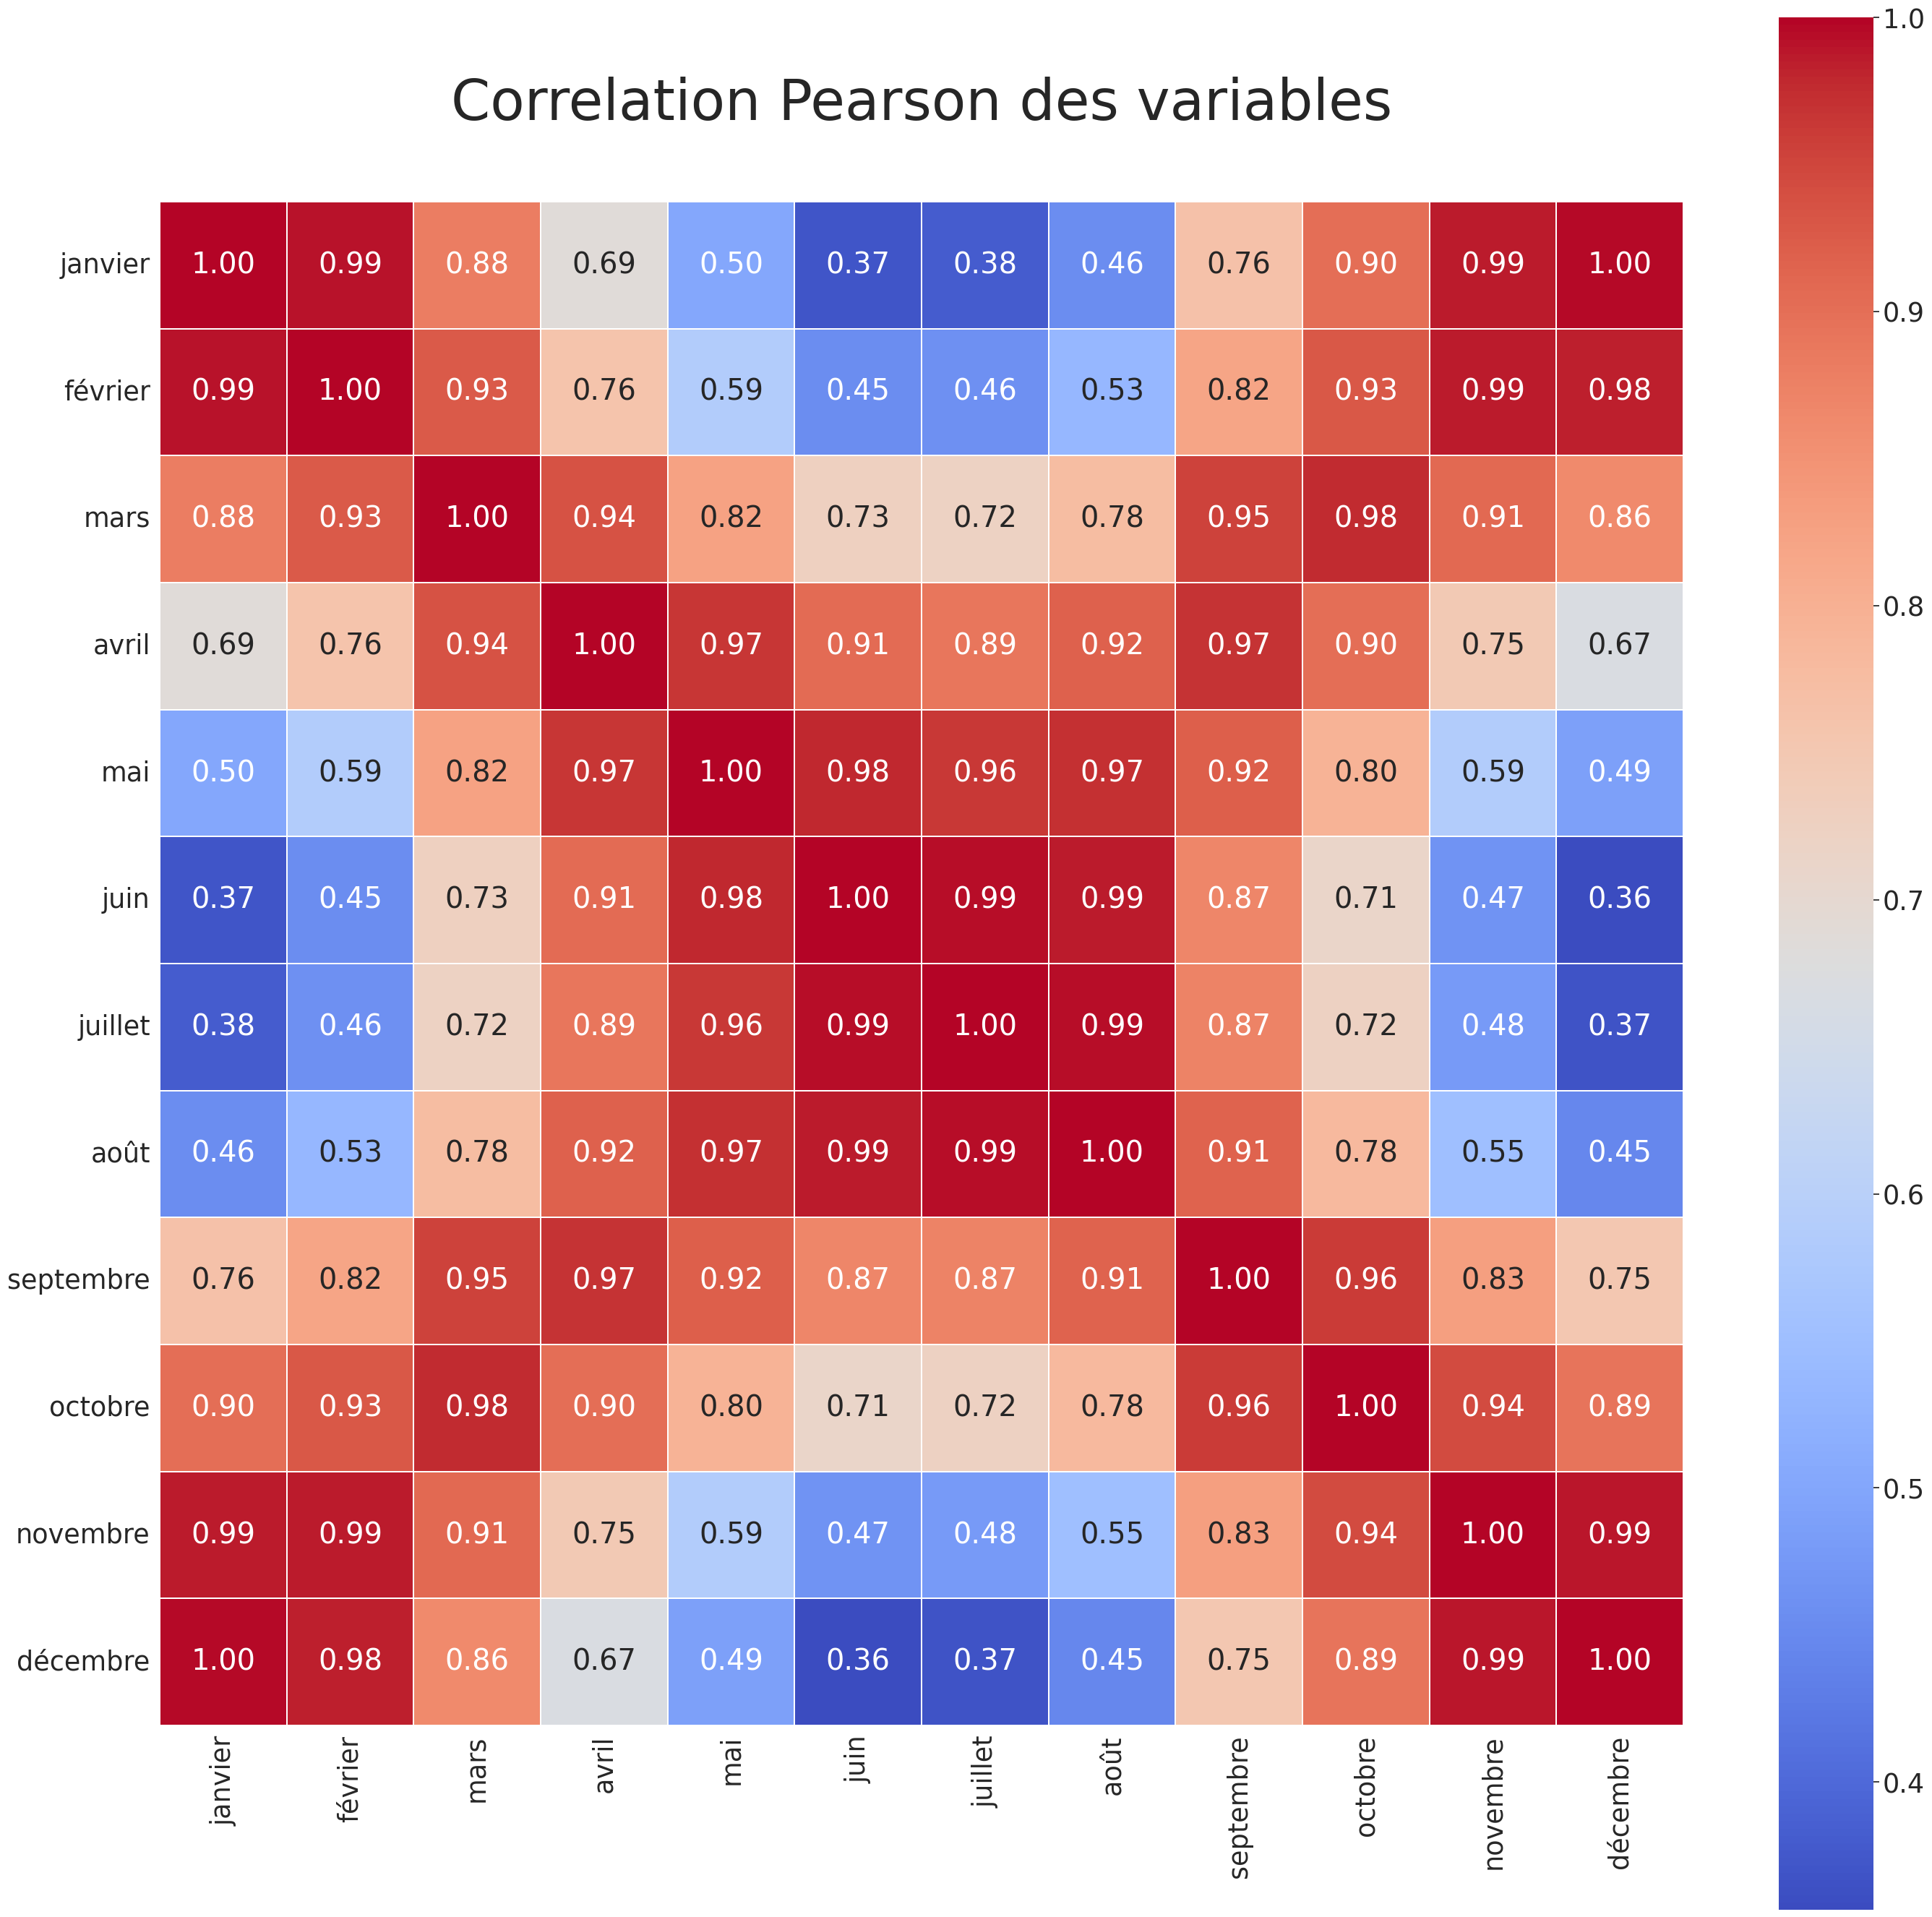

In [10]:
plt.figure(figsize=(34,34))
sns.set(font_scale=2.4)
plt.title('Correlation Pearson des variables', y=1.05, size=56)
sns.heatmap(temperatures.corr(),linewidths=0.3,vmax=1.0, fmt= '.2f', 
            square=True, cmap='coolwarm', linecolor='white', annot=True)
sauvegarderImage('Correlation Pearson des variables--Temperatures')
sns.set(font_scale=2)

# Centrage et réduction des données


<table>
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/moyenne.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/ecart_type.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/centrage_reduction.png"></th>
</tr>
</table>

In [11]:
modelStd = StandardScaler()
modelStd.fit(temperatures)
temperatures[['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août',
              'septembre', 'octobre', 'novembre', 'décembre']] = modelStd.transform(temperatures)
temperatures.head()

janvier   février      mars  \
Nom       Latitude  Longitude Altitude Zone                                 
Abbeville 50.136000 1.834000  69       NO   -0.445705 -0.462325 -0.884145   
Ajaccio   41.918000 8.792667  5        SE    1.650730  1.574472  1.429966   
Alencon   48.445500 0.110167  143      NO   -0.410821 -0.493331 -0.754517   
Bale      47.614333 7.510000  263      NE   -1.500622 -1.401185 -1.194798   
Bastia    42.540667 9.485167  10       SE    1.723055  1.690593  1.536603   

                                                avril       mai      juin  \
Nom       Latitude  Longitude Altitude Zone                                 
Abbeville 50.136000 1.834000  69       NO   -1.026946 -1.174970 -1.287819   
Ajaccio   41.918000 8.792667  5        SE    1.425833  1.447580  1.391617   
Alencon   48.445500 0.110167  143      NO   -0.858793 -0.846860 -0.825463   
Bale      47.614333 7.510000  263      NE   -0.517728 -0.031545  0.087434   
Bastia    42.540667 9.485167  10       SE    1.527189  1.658281  1.632031   

                                              juillet      août  septembre  \
Nom       Latitude  Longitude Altitude Zone                                  
Abbeville 50.136000 1.834000  69       NO   -1.229375 -1.115728  -0.941800   
Ajaccio   41.918000 8.792667  5        SE    1.446350  1.569346   1.834585   
Alencon   48.445500 0.110167  143      NO   -0.822509 -0.856946  -0.896045   
Bale      47.614333 7.510000  263      NE   -0.134988 -0.278213  -0.898789   
Bastia    42.540667 9.485167  10       SE    1.859892  1.987865   2.040467   

                                              octobre  novembre  décembre  
Nom       Latitude  Longitude Altitude Zone                                
Abbeville 50.136000 1.834000  69       NO   -0.800178 -0.495890 -0.442616  
Ajaccio   41.918000 8.792667  5        SE    1.965125  1.949876  1.767797  
Alencon   48.445500 0.110167  143      NO   -0.849844 -0.558013 -0.498610  
Bale      47.614333 7.510000  263      NE   -1.194090 -1.333324 -1.438922  
Bastia    42.540667 9.485167  10       SE    1.939931  1.978465  1.827831

# Analyse en composantes principales

<table>
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/axe_variance_max.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/max_dist.png"></th>
</tr>
</table>



In [12]:
modelPCA = PCA()
modelPCA.fit(temperatures)
modelPCA.explained_variance_ratio_.cumsum()*100

array([ 80.40815139,  98.70992079,  99.48355724,  99.73640711,
        99.85714785,  99.91599333,  99.94461509,  99.96934866,
        99.98668628,  99.99250646,  99.99671156, 100.        ])

## Choix du nombre des dimensions

In [13]:
sum(modelPCA.explained_variance_ratio_.cumsum()*100 <= 95) + 1

2

## Pourcentage d'inertie associée à chaque dimension

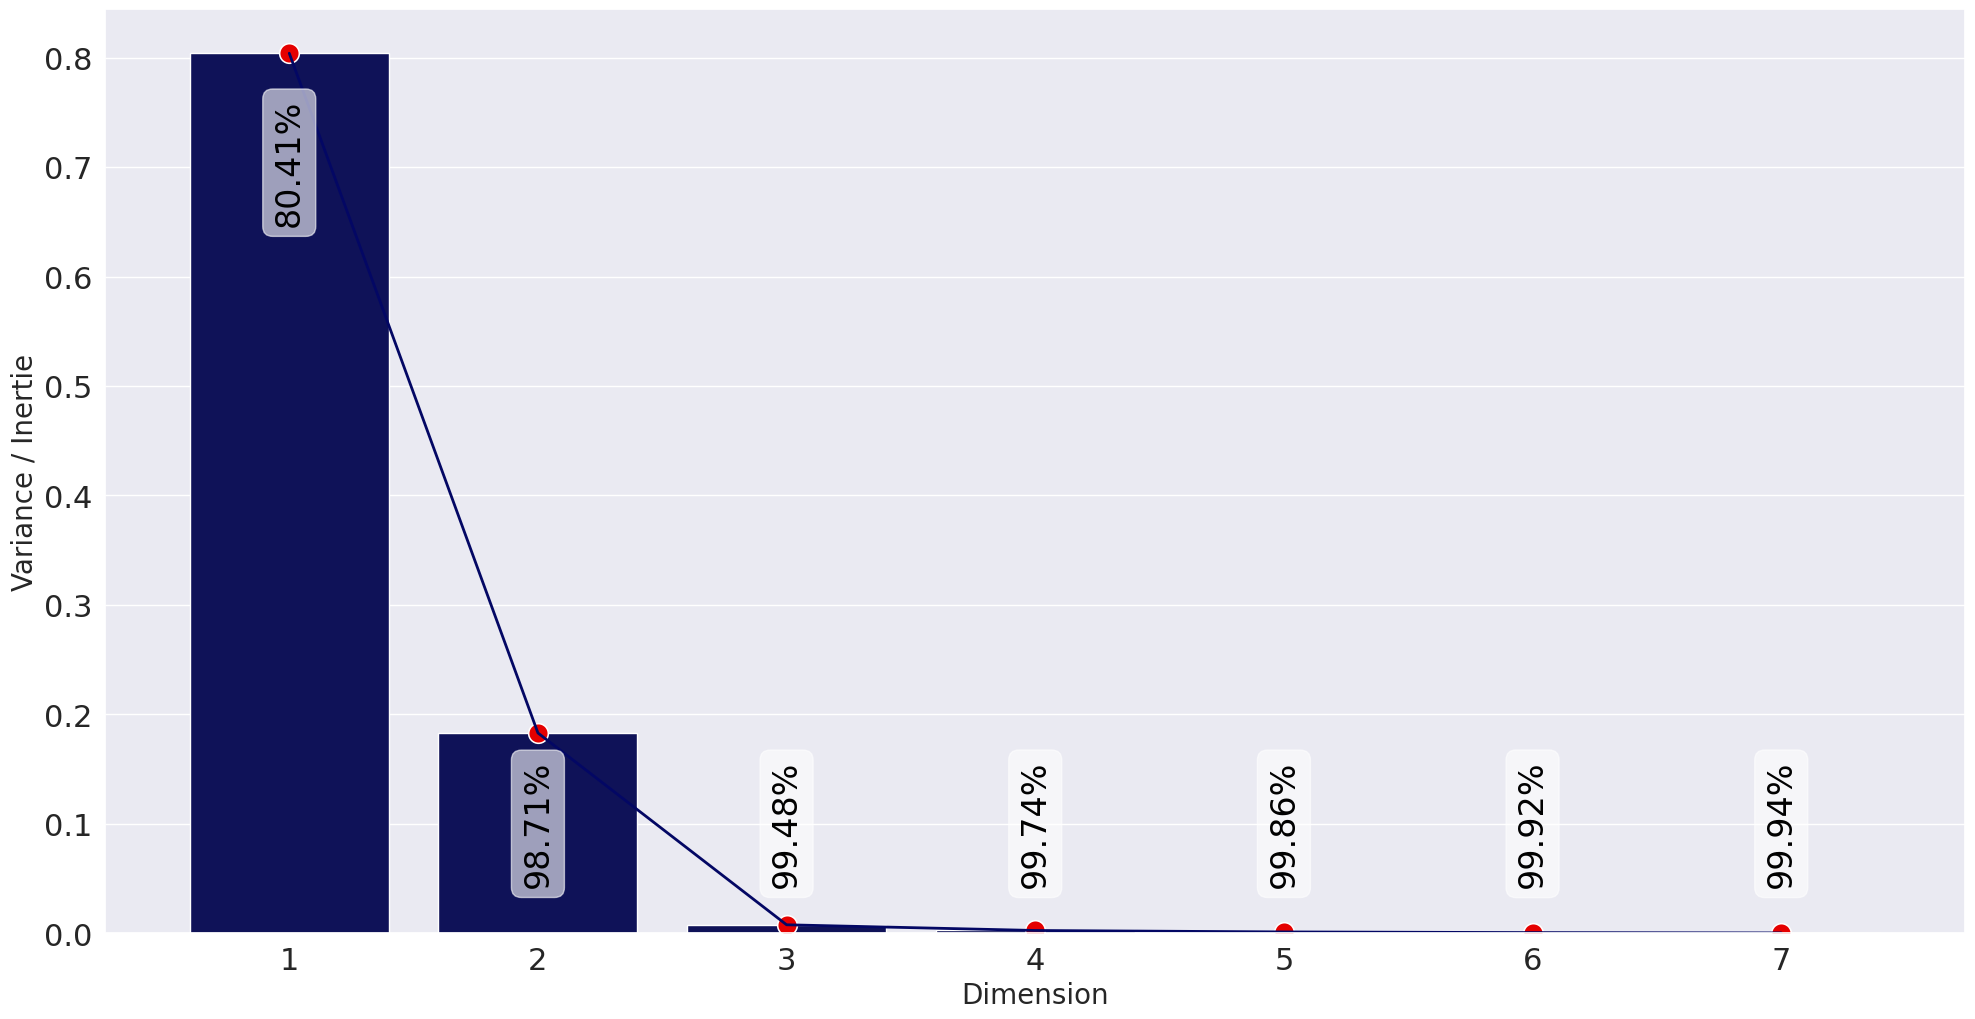

In [14]:
inertie = pd.DataFrame(modelPCA.explained_variance_ratio_,columns=['Inertie']) 
inertie['Label'] = np.round(modelPCA.explained_variance_ratio_.cumsum()*100,2)
inertie['Dimension'] = range(1,len(modelPCA.explained_variance_)+1)
# Affichage des 5 dimensions
dim = 7
inertie = inertie[inertie['Dimension']<= dim]

fig, ax = plt.subplots(figsize=(24,12));
graph = sns.barplot(x="Dimension",y='Inertie', data=inertie, color="#030764", ax=ax)

for i,(nom,valeur) in enumerate(zip(inertie.sort_values('Dimension').Label,inertie.sort_values('Dimension').Inertie)):
    valeur = 0.1 if valeur - 0.1 < 0.1 else valeur - 0.1
    delta =  i 
    graph.text(
                delta ,
                valeur,
                f'{nom}%',
                color='black',
                rotation='vertical',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                verticalalignment='center',
                horizontalalignment='center',
               )
    
graph = sns.lineplot( x=inertie.Dimension - 1,
                      y='Inertie',
                      data=inertie,
                      estimator = None, 
                      lw        = 2, 
                      ci        = None,
                      color     = "#030764",
                      ax    = ax);

sns.scatterplot(x=inertie.Dimension - 1,
                y     = 'Inertie',
                data  = inertie,
                s     = 200,
                # ci    = None, 
                color = "#e50000",
                ax    = ax);    
    
plt.xlabel('Dimension', fontproperties=font1)
plt.ylabel('Variance / Inertie', fontproperties=font1)

sauvegarderImage('Choix du nombre des dimensions--Temperatures')
plt.show()
sns.set(font_scale=2)

## Influence des variables dans les nouvelles dimensions

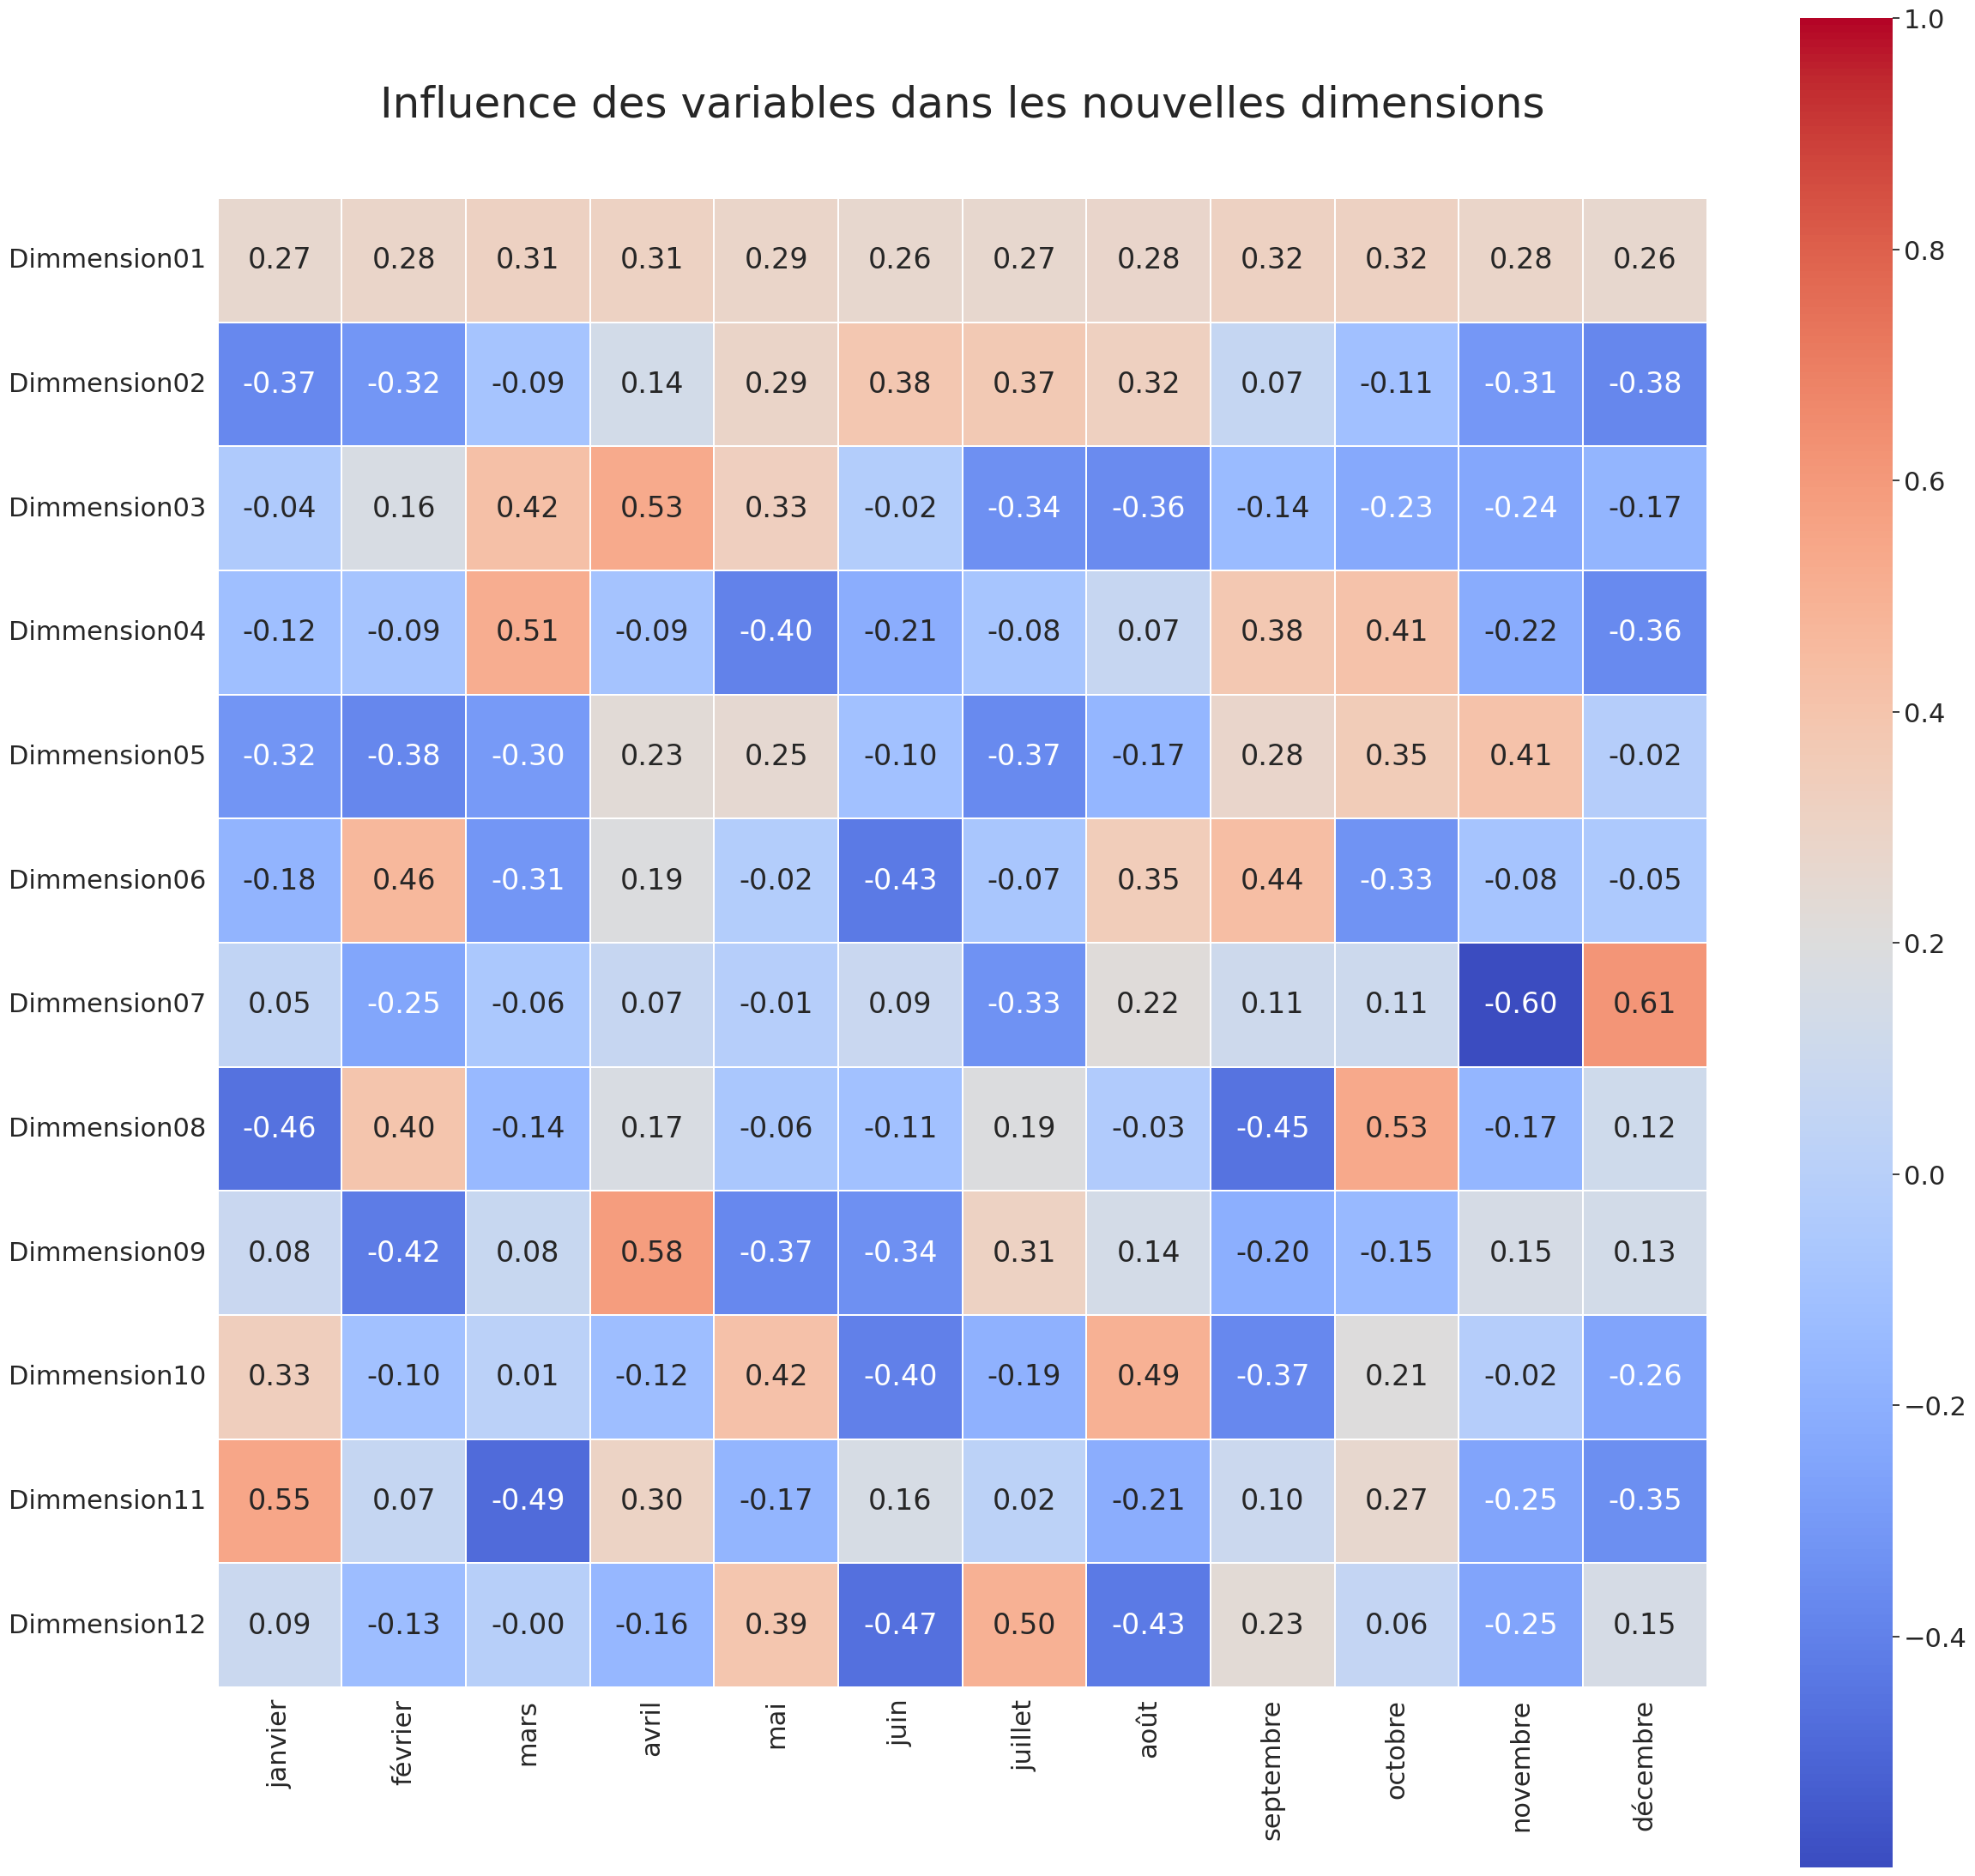

In [15]:
plt.figure(figsize=(28,28))
sns.set(font_scale=2)
plt.title("Influence des variables dans les nouvelles dimensions", y=1.05, size=36)
sns.heatmap(pd.DataFrame(modelPCA.components_, 
                         columns=temperatures.columns, 
                         index=[f'Dimmension{i:02d}' for i in range(1,13)]),
            fmt= '.2f',linewidths=0.3,vmax=1.0, 
            square=True, cmap='coolwarm', linecolor='white', annot=True);
sauvegarderImage('Influence des variables dans les nouvelles dimensions--Temperatures')

## Transformation des données 

In [16]:
n_components = sum(modelPCA.explained_variance_ratio_.cumsum() < .95 ) + 1 
modelPCA = PCA(n_components=n_components)
x_proj = modelPCA.fit_transform(temperatures)
donnees2d = pd.DataFrame(x_proj, index=temperatures.index, columns=[f'Dimension{i:02d}' for i in range(1,n_components+1)])

In [17]:
n_components=3
modelPCA = PCA(n_components=n_components)
x_proj = modelPCA.fit_transform(temperatures)
donnees3d = pd.DataFrame(x_proj, index=temperatures.index, columns=[f'Dimension{i:02d}' for i in range(1,n_components+1)])

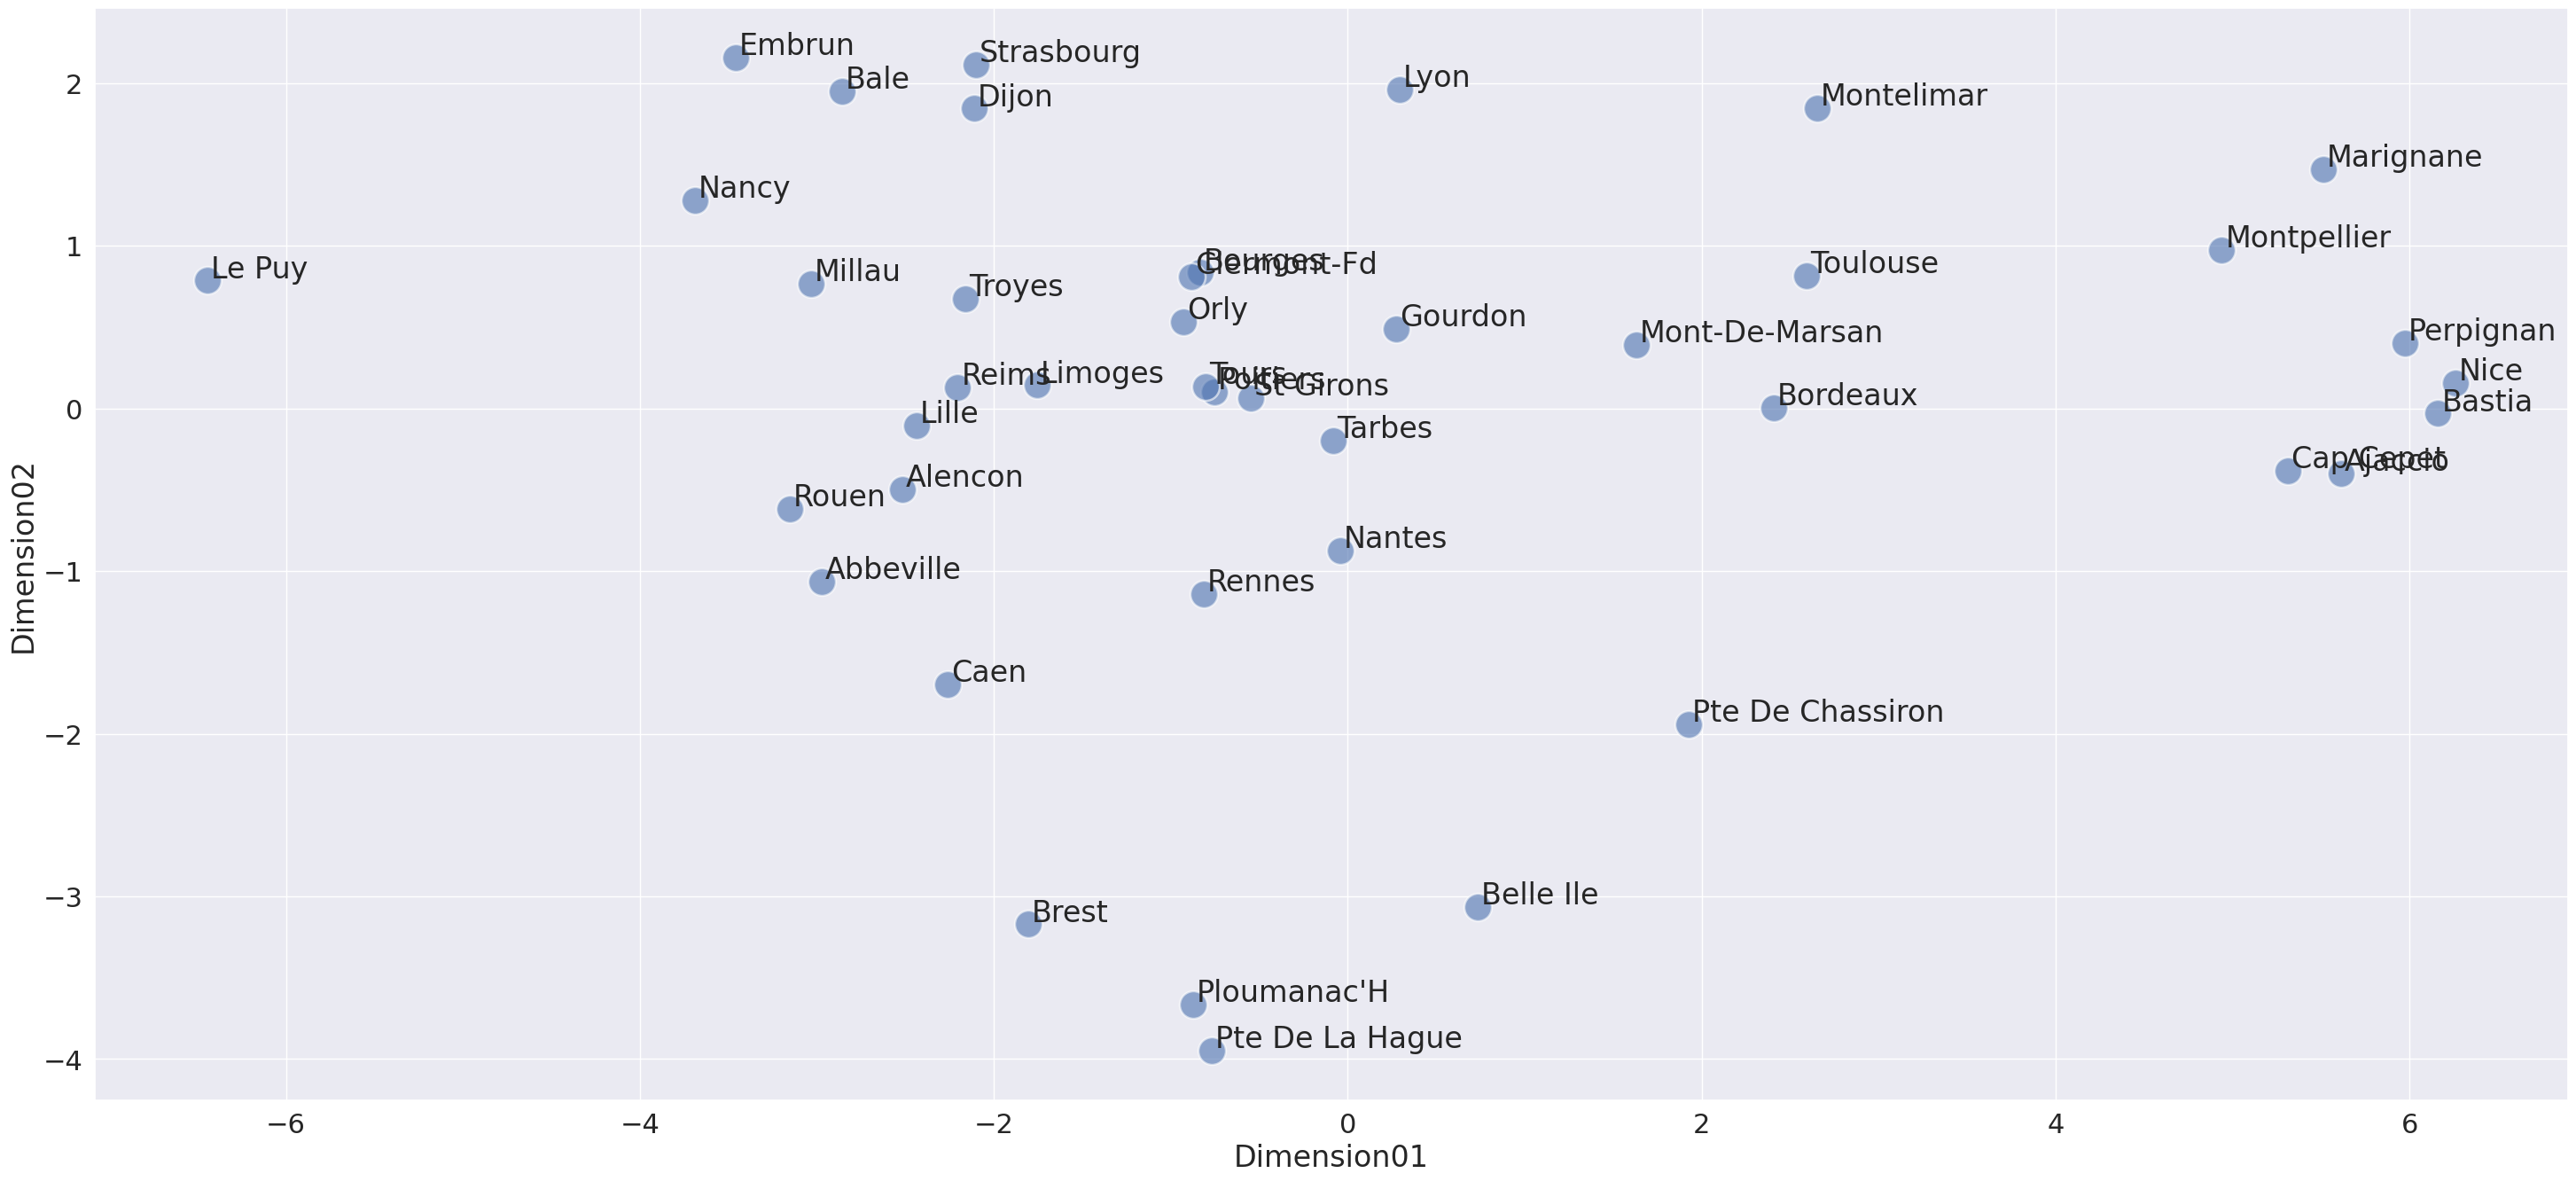

In [18]:
fig, ax = plt.subplots(figsize=(36,16));

affichage = donnees2d.reset_index()
sns.scatterplot(x       = 'Dimension01', 
                y       = 'Dimension02',
                # size    = 'Altitude', 
                # hue     = 'Zone', 
                data    = affichage,
                s       = 500,
                palette = palette,
                alpha=0.6,
                ax=ax
                );

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.02, str(point['val']), fontproperties=font2, rotation=0)

label_point(affichage.Dimension01, affichage.Dimension02, affichage.Nom, ax)        
# sauvegarderImage('Influence des variables dans les nouvelles dimensions--Temperatures')

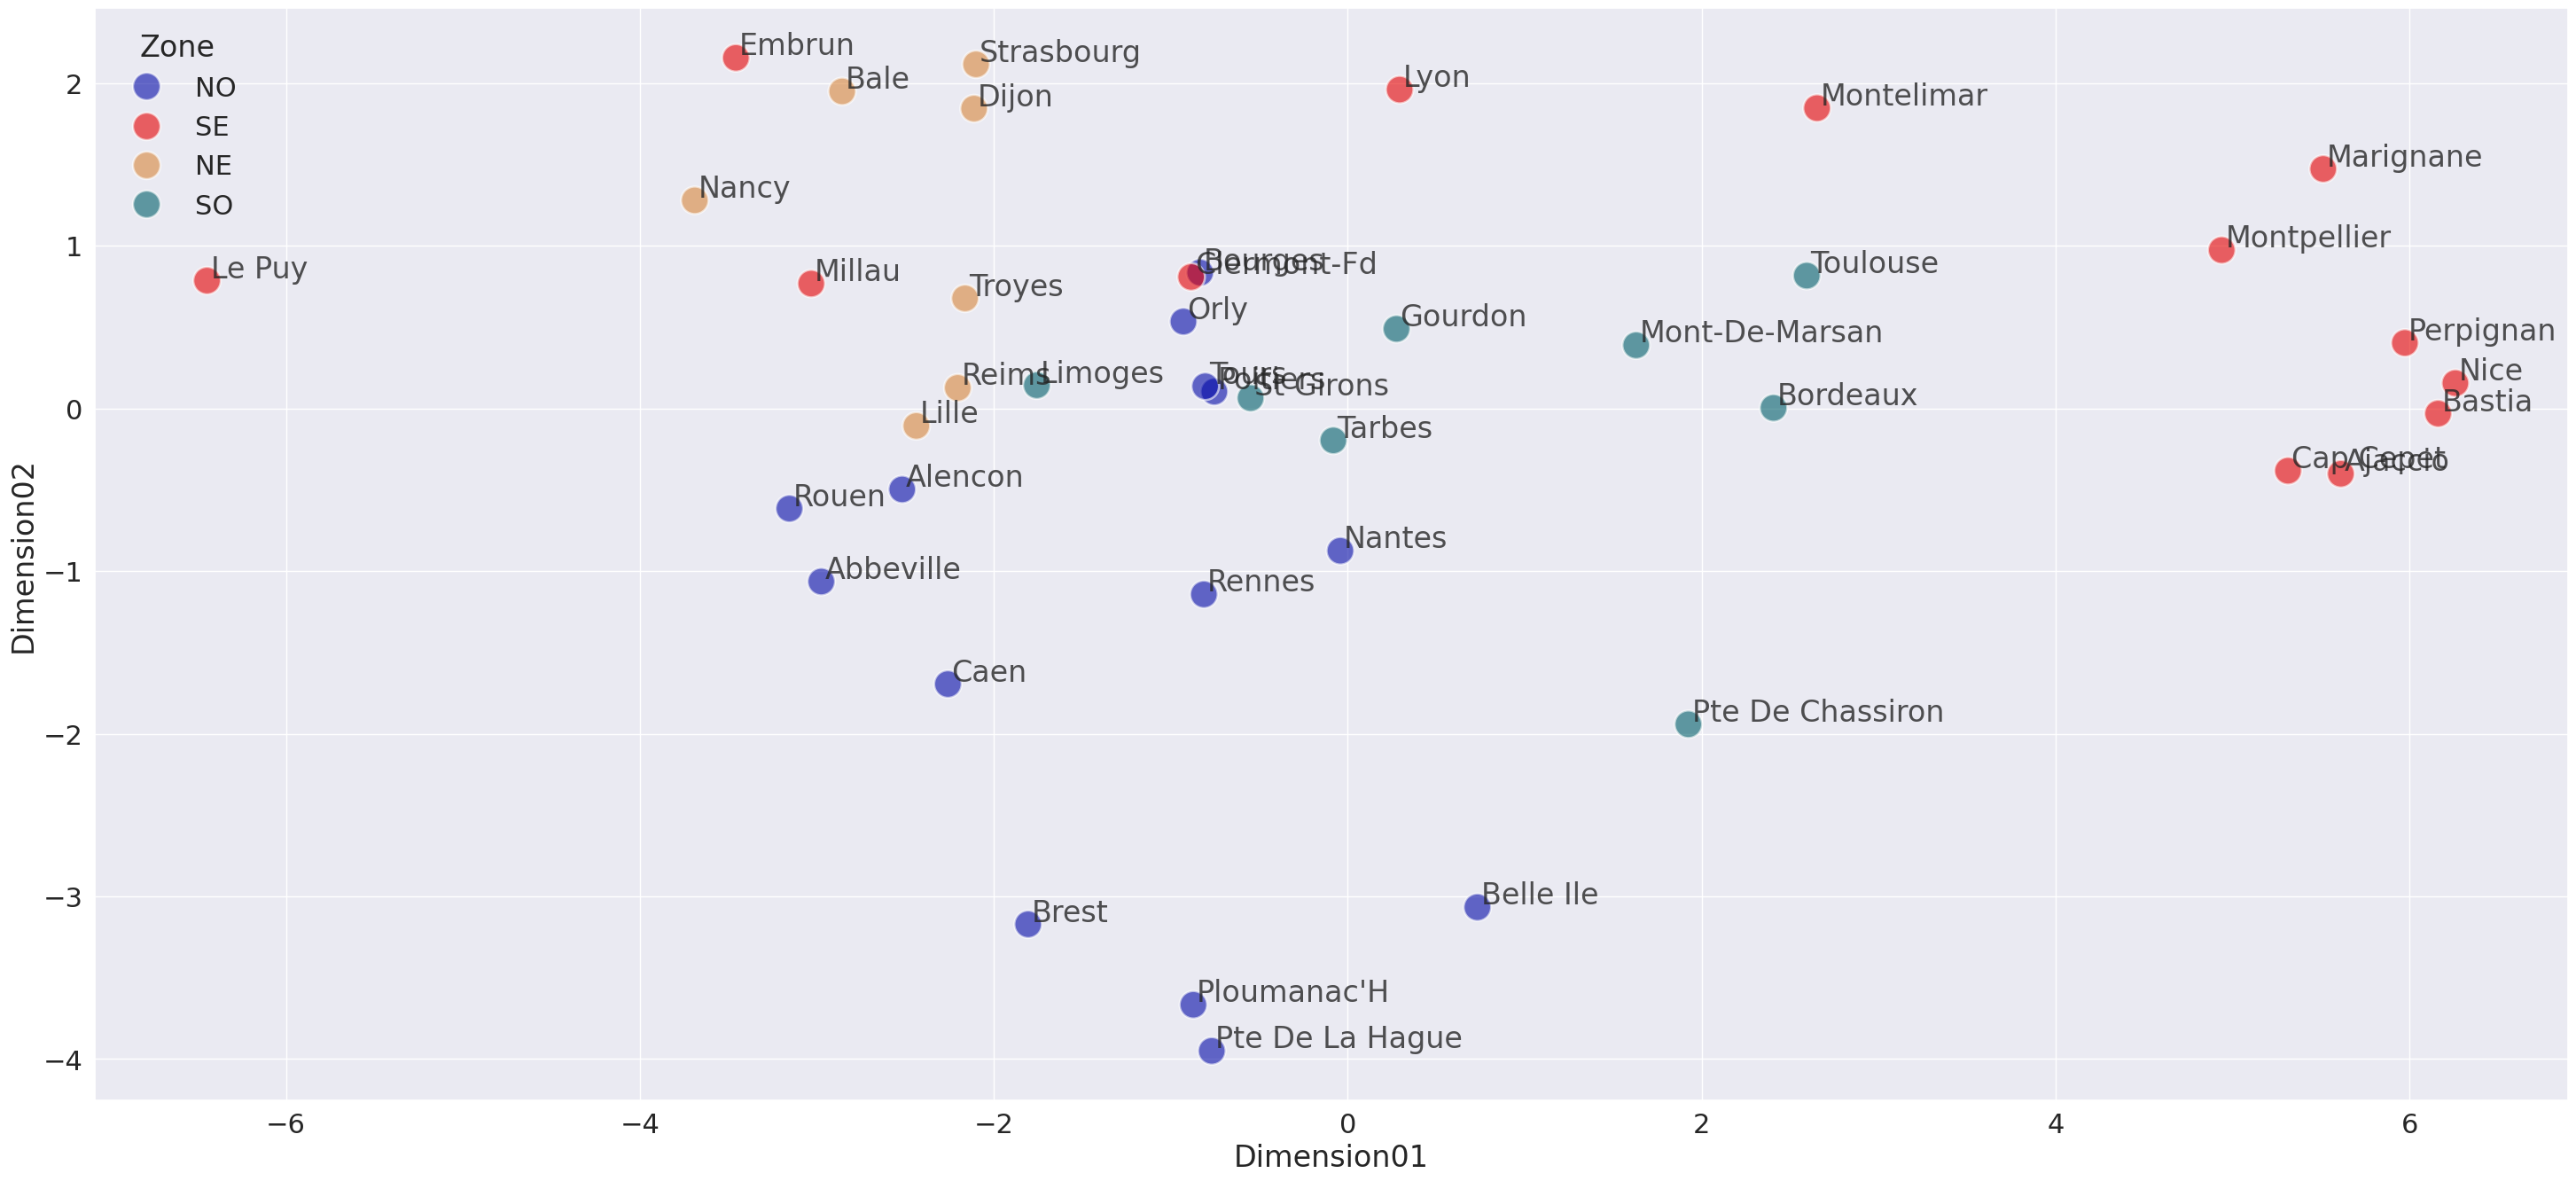

In [19]:
fig, ax = plt.subplots(figsize=(36,16));

affichage = donnees2d.reset_index()
sns.scatterplot(x       = 'Dimension01', 
                y       = 'Dimension02',
                # size    = 'Altitude', 
                hue     = 'Zone', 
                data    = affichage,
                s       = 500,
                palette = palette,
                alpha=0.6,
                ax=ax
                );

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.02, str(point['val']), alpha=0.8, fontproperties=font2, rotation=0)

label_point(affichage.Dimension01, affichage.Dimension02, affichage.Nom, ax)        
# sauvegarderImage('Influence des variables dans les nouvelles dimensions--Temperatures')

In [20]:
layout = go.Layout({"showlegend": False})

fig = px.scatter_3d(donnees3d.reset_index(), 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='Zone',
#                     size=100+donnees3d.reset_index().Altitude,
#                     symbol=donnees.CD23.cat.codes,
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()

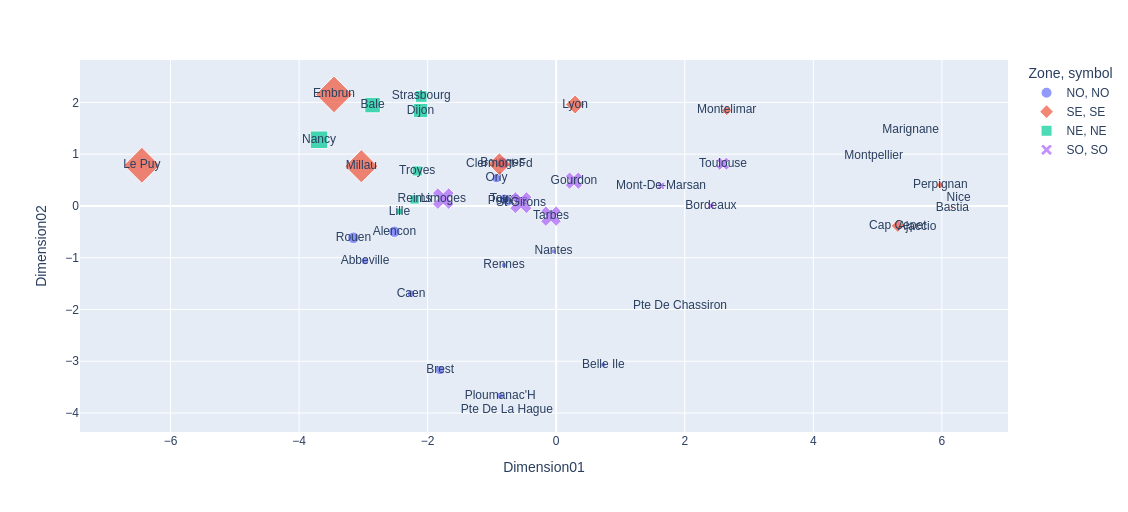

In [21]:
fig = px.scatter( donnees2d.reset_index(), 
                  x='Dimension01', 
                  y='Dimension02', 
                  color='Zone',
                  size=donnees2d.reset_index().Altitude,
                  symbol=donnees2d.reset_index().Zone,
                  text='Nom',
                  width=1024,
                  height=512,
                  )

fig.show()